# STFT demo

# Understanding the Spectrogram Plot

The **spectrogram** plot, derived from the **Short-Time Fourier Transform (STFT)**, provides a **time-frequency representation** of the signal. Here’s what you can understand from the spectrogram:

## Key Observations from the Spectrogram

1. **Frequency Content Over Time**:
   - The spectrogram shows how the signal's **frequency content changes with time**.
   - For example:
     - A **5 Hz component** might appear at the start and end.
     - A **50 Hz component** might appear only between 0.5 and 1.5 seconds.

2. **Time Localization**:
   - The spectrogram reveals **when specific frequencies are active**.
   - For instance:
     - A **50 Hz component** active for 1 second (e.g., from 0.5 to 1.5 seconds).
     - A **5 Hz component** active throughout.

3. **Amplitude (Intensity)**:
   - The color intensity in the spectrogram indicates the **amplitude** (or power) of the frequency at a given time.
   - Brighter regions correspond to higher amplitudes, while darker regions indicate lower amplitudes.

4. **Harmonics**:
   - In more complex signals (like speech or music), the spectrogram can reveal **harmonics** — evenly spaced frequency components associated with the fundamental frequency.

5. **Time-Frequency Tradeoff**:
   - The resolution of the spectrogram depends on the **STFT window size**:
     - **Larger Window (n_fft)**:
       - Better frequency resolution but poorer time resolution.
       - Useful for signals with slowly changing frequency.
     - **Smaller Window (n_fft)**:
       - Better time resolution but poorer frequency resolution.
       - Useful for signals with rapid changes in frequency.

---

## What the Spectrogram Teaches Us

- **Insight into Time-Varying Signals**:
  - Signals like speech, music, or animal calls often have time-varying frequency content. A spectrogram reveals these variations clearly.

- **Signal Composition**:
  - By observing the spectrogram, you can infer which frequencies dominate the signal at specific times.

- **Noise and Distortions**:
  - Noise appears as random, broad-spectrum activity in the spectrogram, which can be visually distinguished from structured patterns.

---

## Example Interpretation from the Code

For the provided signal:
1. The **5 Hz component**:
   - Visible as a horizontal line near 5 Hz across the entire duration.
2. The **50 Hz component**:
   - A horizontal line at 50 Hz appears between 0.5 and 1.5 seconds.
3. **Amplitude**:
   - The 5 Hz and 50 Hz components may have different intensities, visible as varying brightness in the spectrogram.

---

## Applications of Spectrograms

- **Speech and Audio Processing**:
  - Analyzing speech phonemes or identifying musical notes.
- **Biomedical Signals**:
  - Understanding EEG or heart rate variability.
- **Machine Learning**:
  - Using spectrograms as input features for audio classification tasks.
- **Engineering Diagnostics**:
  - Detecting anomalies in mechanical or electrical systems.


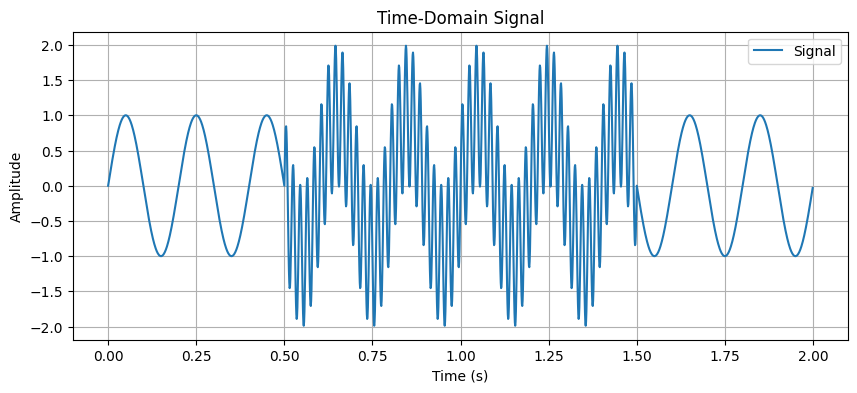

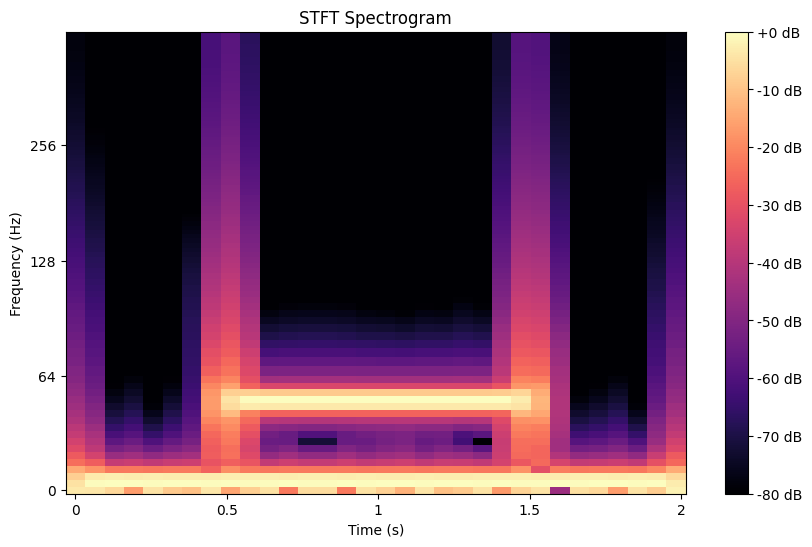

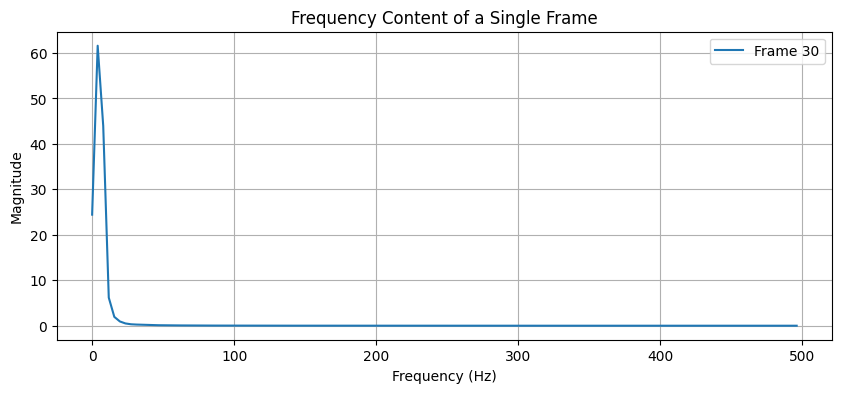

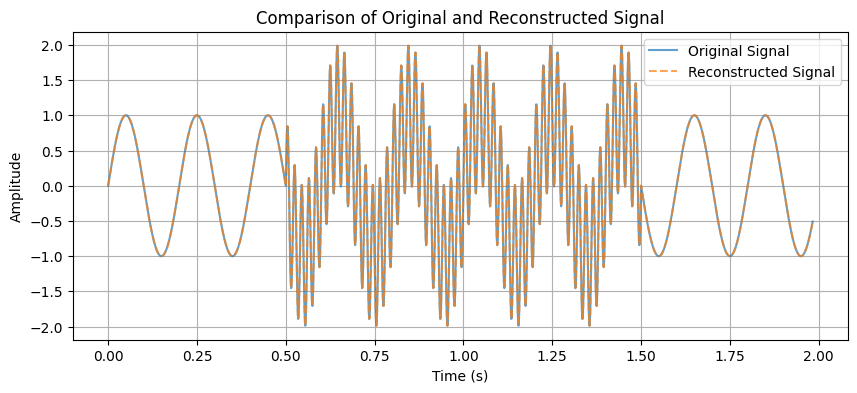

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Function to align signals
def align_signals(signal1, signal2):
    min_length = min(len(signal1), len(signal2))
    return signal1[:min_length], signal2[:min_length]

# Generate a test signal (a sine wave with varying frequency)
sr = 1000  # Sampling rate (Hz)
t = np.linspace(0, 2, 2 * sr, endpoint=False)  # 2 seconds of time
signal = np.sin(2 * np.pi * 5 * t)  # 5 Hz sine wave
signal[int(0.5 * sr):int(1.5 * sr)] += np.sin(2 * np.pi * 50 * t[int(0.5 * sr):int(1.5 * sr)])  # Add 50 Hz in the middle

# Plot the time-domain signal
plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Signal")
plt.title("Time-Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()

# Perform STFT
n_fft = 256  # Length of the FFT window
hop_length = 64  # Number of samples to hop between windows
stft_result = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
stft_magnitude = np.abs(stft_result)

# Visualize the STFT (Spectrogram)
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(stft_magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("STFT Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# Analyze a single frame
frame_index = 30  # Choose a frame to analyze
frame = stft_result[:, frame_index]
freqs = np.fft.fftfreq(n_fft, d=1/sr)[:n_fft//2]

plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(frame[:n_fft//2]), label=f"Frame {frame_index}")
plt.title("Frequency Content of a Single Frame")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.show()

# Reconstruct the signal using inverse STFT
reconstructed_signal = librosa.istft(stft_result, hop_length=hop_length)

# Align original and reconstructed signals
aligned_original, aligned_reconstructed = align_signals(t, reconstructed_signal)

# Plot the original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.plot(t[:len(aligned_original)], signal[:len(aligned_original)], label="Original Signal", alpha=0.7)
plt.plot(t[:len(aligned_reconstructed)], aligned_reconstructed, '--', label="Reconstructed Signal", alpha=0.7)
plt.title("Comparison of Original and Reconstructed Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


# Speech denoising application

# Speech Denoising: Theory and Demonstration

Speech denoising is the process of reducing noise in a noisy speech signal while preserving the intelligibility and naturalness of the speech. This is a critical task in many applications, such as telecommunications, hearing aids, and automatic speech recognition.

---

## Theoretical Concepts

### 1. **Noisy Speech Model**
A noisy speech signal $y(t)$ can be represented as:
$$
y(t) = x(t) + n(t)
$$
where:
- $x(t)$ is the clean speech signal,
- $n(t)$ is the noise,
- $y(t)$ is the observed noisy speech.

The goal of speech denoising is to estimate $x(t)$ from $y(t)$, effectively suppressing $n(t)$.

---

### 2. **Short-Time Fourier Transform (STFT)**
The STFT is used to transform the signal into the **time-frequency domain**, allowing noise suppression to be applied separately to different frequency bands. The STFT of a signal $x(t)$ is defined as:
$$
X(k, m) = \sum_{n} x(n) w(n - mL) e^{-j2\pi kn/N}
$$
where:
- $X(k, m)$ is the STFT coefficient at frequency bin $k$ and time frame $m$,
- $w(n)$ is a window function,
- $L$ is the hop size,
- $N$ is the FFT size.

The **magnitude** and **phase** of the STFT are used:
- The **magnitude** contains most of the information about the signal's power.
- The **phase** is crucial for reconstructing the signal accurately.

---

### 3. **Wiener Filtering for Noise Suppression**
Wiener filtering is a popular method for speech denoising. It works by computing a gain function $G(k, m)$ to scale the noisy STFT coefficients:
$$
G(k, m) = \frac{S(k, m)}{S(k, m) + N(k, m)}
$$
where:
- $S(k, m)$ is the power spectral density (PSD) of the clean speech,
- $N(k, m)$ is the PSD of the noise.

The gain is applied to the noisy STFT:
$$
\hat{X}(k, m) = G(k, m) Y(k, m)
$$
where:
- $\hat{X}(k, m)$ is the estimated clean speech STFT,
- $Y(k, m)$ is the noisy speech STFT.

The estimated clean speech is reconstructed using the **inverse STFT (ISTFT)**.

---

## Demonstration Overview

### 1. **Test Signal Creation**
- A clean speech signal is loaded.
- Gaussian noise is added to simulate a noisy speech signal.
- The Signal-to-Noise Ratio (SNR) determines the noise level.

### 2. **STFT of Noisy Speech**
- The STFT of the noisy speech is computed to visualize the signal in the time-frequency domain.
- The first few frames of the STFT are used to estimate the noise power spectral density (PSD).

### 3. **Wiener Filtering**
- A Wiener filter gain is calculated based on the estimated noise PSD and the noisy signal's PSD.
- The gain is applied to suppress noise in the time-frequency domain.

### 4. **Signal Reconstruction**
- The cleaned signal is reconstructed using the ISTFT.
- The denoised speech is compared with the noisy and clean speech signals in both the time and frequency domains.

---

## Key Plots and Their Interpretations

1. **Time-Domain Signals**:
   - The clean speech, noisy speech, noise, and denoised speech are plotted.
   - This shows how noise affects the amplitude of the signal and how denoising restores the clean signal.

2. **Spectrograms**:
   - Spectrograms visualize the time-frequency content of the clean, noisy, noise, and denoised signals.
   - The noise appears as random, broad-spectrum activity, while speech shows structured patterns.
   - After denoising, the spectrogram of the denoised signal should closely resemble the clean speech spectrogram.

3. **Performance Metrics**:
   - **Input SNR**: Quantifies the noise level in the original noisy signal.
   - **Output SNR**: Measures the noise level in the denoised signal.
   - **SNR Improvement ($\Delta SNR$)**: Indicates how much the noise has been reduced.

---

## Practical Applications

1. **Telecommunications**:
   - Enhancing the quality of voice calls in noisy environments.
2. **Hearing Aids**:
   - Improving speech intelligibility for people with hearing impairments.
3. **Automatic Speech Recognition**:
   - Preprocessing noisy input to improve system accuracy.
4. **Biomedical Signal Processing**:
   - Denoising signals like EEG or heart sounds contaminated with noise.

This demonstration highlights the effectiveness of STFT-based speech denoising and its application in real-world scenarios.


Input SNR (Noisy Speech): 10.01 dB
Output SNR (Denoised Speech): 13.76 dB
SNR Improvement (ΔSNR): 3.74 dB


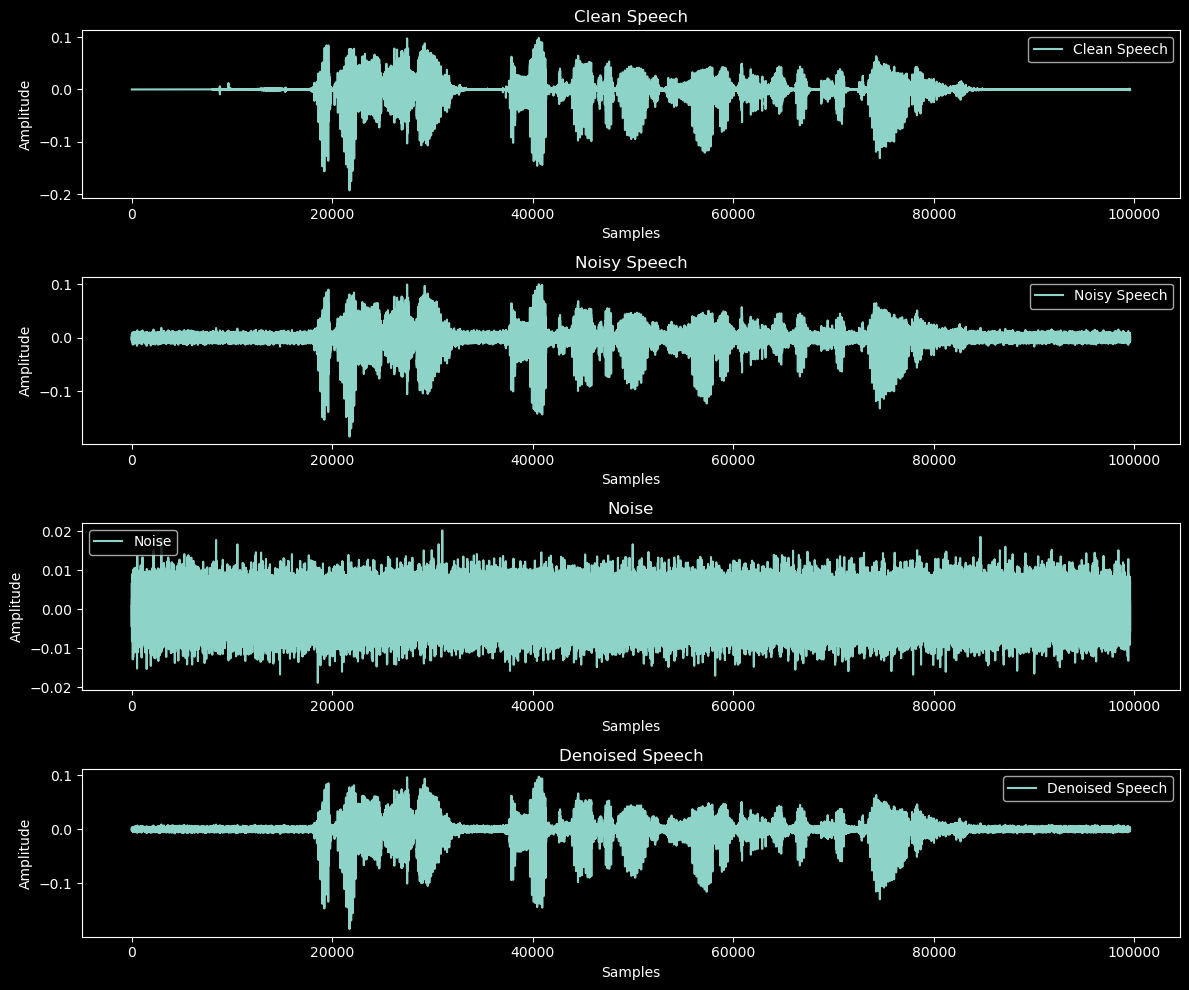

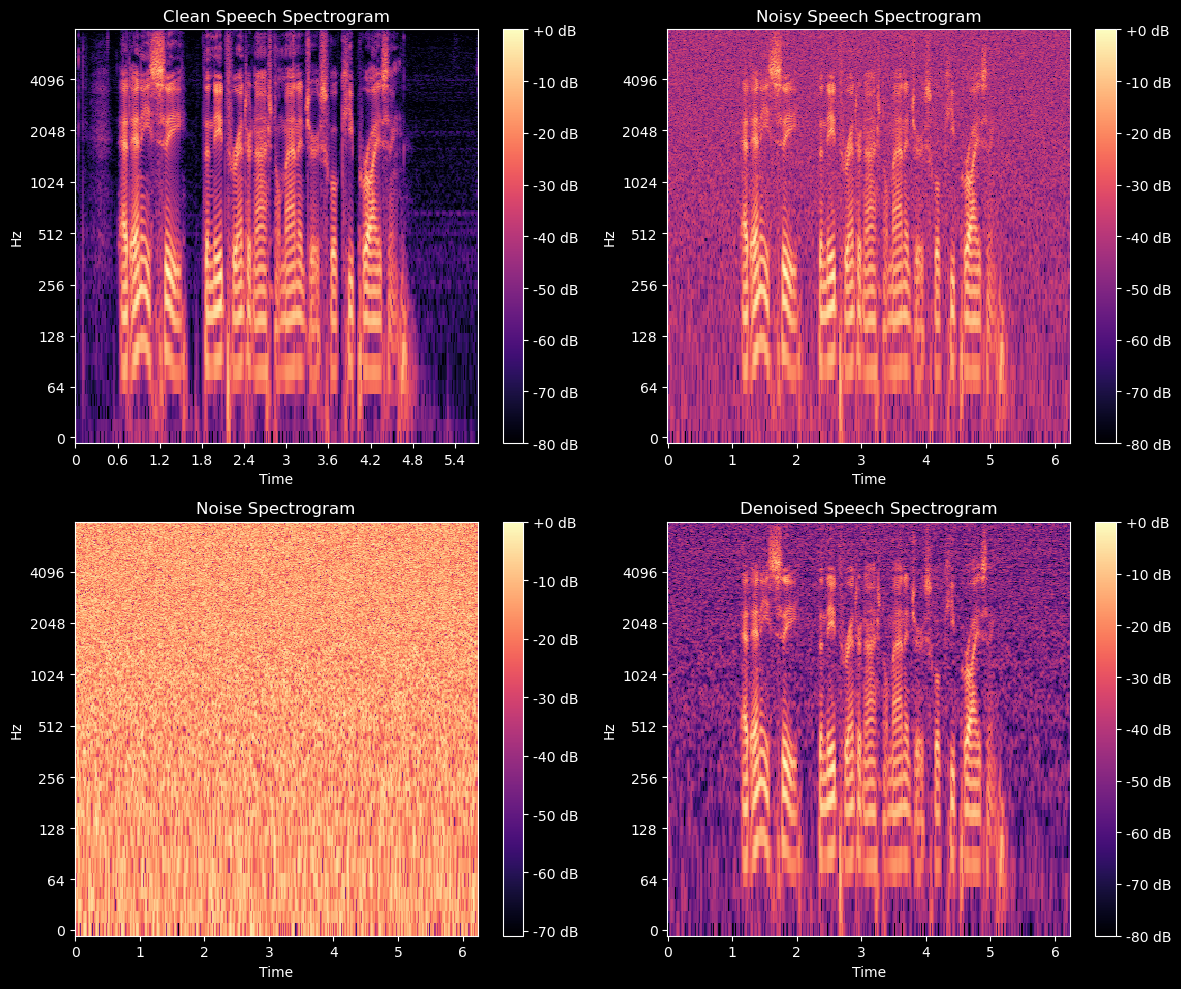

Clean Speech:


Noisy Speech:


Noise:


Denoised Speech:


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

# Function to calculate SNR
def calculate_snr(clean, estimated):
    noise = clean - estimated
    signal_power = np.sum(clean ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to align signals to the same length
def align_signals(*signals):
    min_length = min(len(signal) for signal in signals)
    return [signal[:min_length] for signal in signals]

# Load the clean speech signal
clean_speech_path = 'data/test_speech/s.wav'  # Replace with the path to the clean speech file
clean_speech, sr = librosa.load(clean_speech_path, sr=None)

# Define parameters
target_snr_db = 10  # Target SNR in dB
zero_padding_duration = 0.5  # Duration of zero-padding in seconds
noise_frames = 10  # Number of frames used for noise PSD estimation

# Zero-pad the beginning of the clean speech signal
zero_padding_samples = int(zero_padding_duration * sr)
padded_clean_speech = np.concatenate((np.zeros(zero_padding_samples), clean_speech))

# Compute the power of the clean speech signal
clean_power = np.mean(padded_clean_speech ** 2)

# Compute the noise power for the given SNR
target_snr_linear = 10 ** (target_snr_db / 10)
noise_power = clean_power / target_snr_linear

# Generate Gaussian noise
noise = np.sqrt(noise_power) * np.random.randn(len(padded_clean_speech))

# Create the noisy speech signal
noisy_speech = padded_clean_speech + noise

# Save the noisy speech for future analysis
sf.write('noisy_speech.wav', noisy_speech, sr)

# Perform STFT
n_fft = 1024
hop_length = 256
win_length = 1024

# STFT of noisy speech
stft_noisy = librosa.stft(noisy_speech, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
magnitude_noisy = np.abs(stft_noisy)

# Noise PSD estimation from the first few frames
stft_noisy_initial = stft_noisy[:, :noise_frames]
noise_psd = np.mean(np.abs(stft_noisy_initial) ** 2, axis=1, keepdims=True)

# Compute Wiener filter and apply it
signal_power = magnitude_noisy ** 2

# Standard Wiener Filter Gain
wiener_filter = signal_power / (signal_power + noise_psd)

# Modified Wiener Filter Gain Formula
beta = 1.5  # Power-law exponent
G_min = 0.1  # Residual noise floor (minimum gain)

# Compute the modified gain
modified_gain = (signal_power / (signal_power + noise_psd)) ** beta
wiener_filter = np.maximum(modified_gain, G_min)  # Enforce minimum gain

filtered_stft = wiener_filter * stft_noisy
denoised_speech = librosa.istft(filtered_stft, hop_length=hop_length, win_length=win_length)

# Align all signals before calculating metrics
aligned_clean, aligned_noisy, aligned_denoised = align_signals(
    padded_clean_speech, noisy_speech, denoised_speech
)

# Calculate metrics
input_snr = calculate_snr(aligned_clean, aligned_noisy)
output_snr = calculate_snr(aligned_clean, aligned_denoised)
delta_snr = output_snr - input_snr

# Print metrics
print(f"Input SNR (Noisy Speech): {input_snr:.2f} dB")
print(f"Output SNR (Denoised Speech): {output_snr:.2f} dB")
print(f"SNR Improvement (ΔSNR): {delta_snr:.2f} dB")

# Plot time-domain signals
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(aligned_clean, label="Clean Speech")
plt.title("Clean Speech")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(aligned_noisy, label="Noisy Speech")
plt.title("Noisy Speech")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(noise[:len(aligned_clean)], label="Noise")
plt.title("Noise")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(aligned_denoised, label="Denoised Speech")
plt.title("Denoised Speech")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Plot spectrograms in 2x2 subplots
plt.figure(figsize=(12, 10))

# Clean speech spectrogram
plt.subplot(2, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(clean_speech, n_fft=n_fft), ref=np.max),
                         sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title("Clean Speech Spectrogram")
plt.colorbar(format='%+2.0f dB')

# Noisy speech spectrogram
plt.subplot(2, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(magnitude_noisy, ref=np.max),
                         sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title("Noisy Speech Spectrogram")
plt.colorbar(format='%+2.0f dB')

# Noise spectrogram
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(noise, n_fft=n_fft), ref=np.max),
                         sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title("Noise Spectrogram")
plt.colorbar(format='%+2.0f dB')

# Denoised speech spectrogram
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(denoised_speech, n_fft=n_fft), ref=np.max),
                         sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title("Denoised Speech Spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Play buttons for all signals
print("Clean Speech:")
display(Audio(clean_speech, rate=sr))

print("Noisy Speech:")
display(Audio(noisy_speech, rate=sr))

print("Noise:")
display(Audio(noise, rate=sr))

print("Denoised Speech:")
display(Audio(denoised_speech, rate=sr))


In [ ]:
impo